# **Stock Price Prediction Using LSTM Combined Dataset Model**

### Importing Libraries

In [94]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import random as python_random
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Input
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [95]:
# Fix random seed for reproducibility
np.random.seed(1)
python_random.seed(1)
tf.random.set_seed(1)

### Data Collection

In [96]:
# Load the combined dataset for Apple stocks
combined_df = pd.read_csv('AAPL_Combined_dataset.csv', index_col=0)
combined_df.index = pd.to_datetime(combined_df.index)
combined_df

,compound,positive,neutral,negative,Open,High,Low,Close,Adj Close,Volume
2015-01-02,0.083845,0.089467,0.865566,0.044968,27.847500,27.860001,26.837500,27.332500,24.402170,2.128184e+08
2015-01-03,0.215933,0.122315,0.850419,0.027257,27.589167,27.627501,26.675833,27.075834,24.173021,2.275929e+08
2015-01-04,0.191860,0.109387,0.864534,0.026074,27.330833,27.395000,26.514167,26.819167,23.943871,2.423675e+08
2015-01-05,0.116226,0.099225,0.855036,0.045738,27.072500,27.162500,26.352501,26.562500,23.714722,2.571420e+08
2015-01-06,0.136152,0.109782,0.846006,0.044217,26.635000,26.857500,26.157499,26.565001,23.716955,2.631884e+08
...,...,...,...,...,...,...,...,...,...,...
2019-12-26,0.147643,0.100492,0.863174,0.036327,71.205002,72.495003,71.175003,72.477501,70.424393,9.312120e+07
2019-12-27,0.139579,0.101420,0.856126,0.042444,72.779999,73.492500,72.029999,72.449997,70.397675,1.462660e+08
2019-12-28,0.154987,0.094781,0.884576,0.020638,72.641665,73.385834,71.788333,72.593330,70.536949,1.455488e+08
2019-12-29,0.185072,0.109205,0.861089,0.029711,72.503332,73.279167,71.546666,72.736664,70.676224,1.448316e+08


### Data Preprocessing

In [97]:
print(combined_df.isnull().sum())

compound     7
positive     7
neutral      7
negative     7
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [98]:
combined_df.fillna(0, inplace=True)

In [99]:
print(combined_df.isnull().sum())

compound     0
positive     0
neutral      0
negative     0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


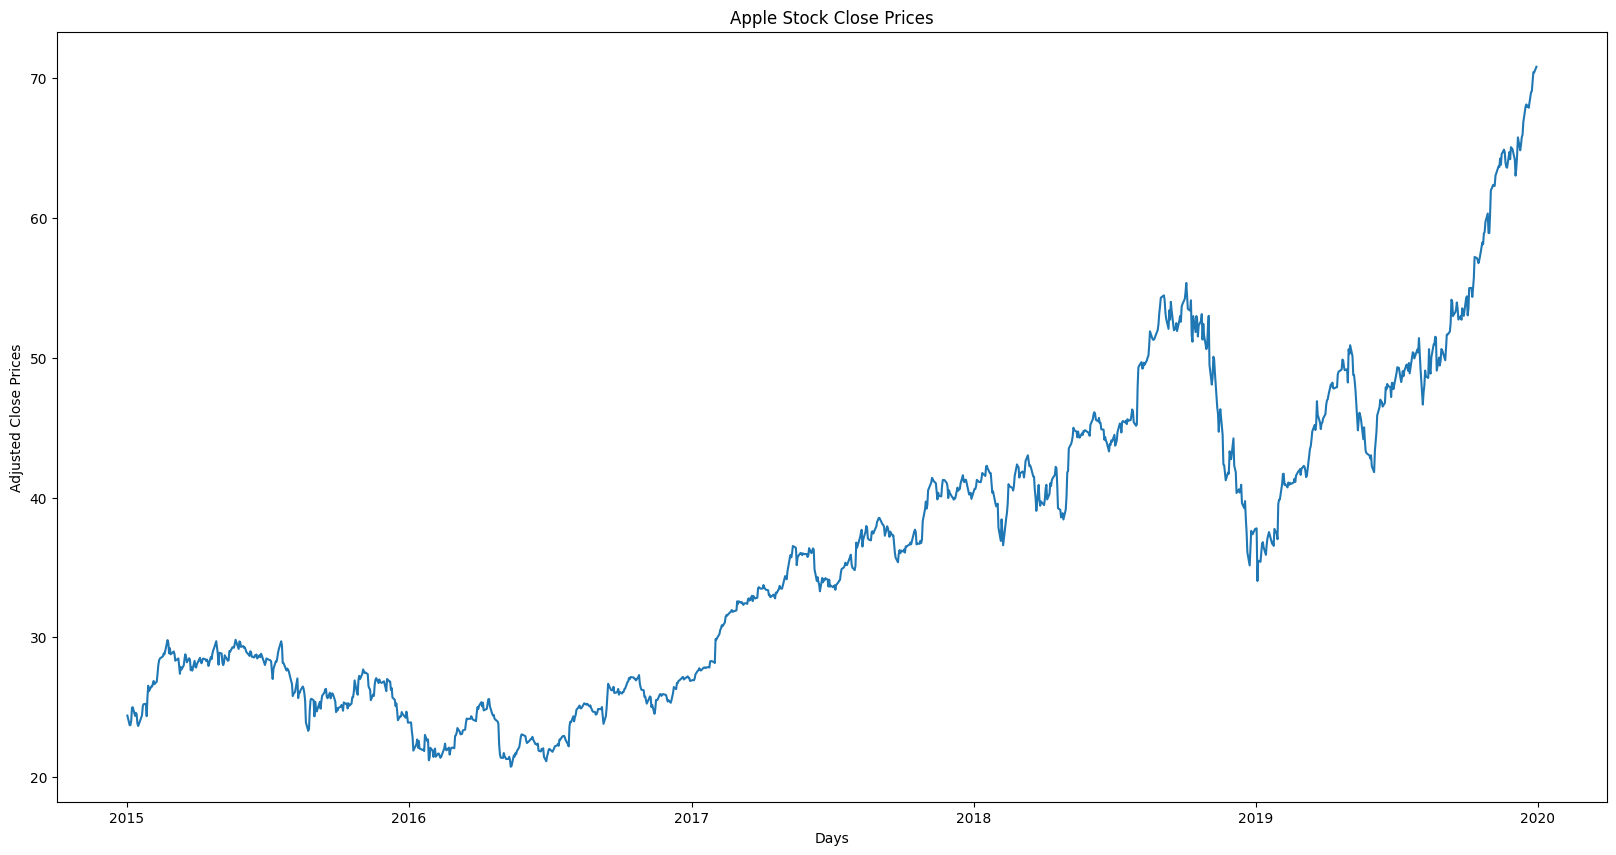

In [100]:
# Plot historical stock data
plt.figure(figsize=(20, 10))
plt.xlabel('Days')
plt.ylabel('Adjusted Close Prices')
plt.title('Apple Stock Close Prices')
plt.plot(combined_df['Adj Close'])
plt.show()

### Feature Creation

In [101]:
combined_df['Price difference'] = combined_df['Adj Close'].diff()
combined_df.dropna(inplace=True)
combined_df

,compound,positive,neutral,negative,Open,High,Low,Close,Adj Close,Volume,Price difference
2015-01-03,0.215933,0.122315,0.850419,0.027257,27.589167,27.627501,26.675833,27.075834,24.173021,2.275929e+08,-0.229150
2015-01-04,0.191860,0.109387,0.864534,0.026074,27.330833,27.395000,26.514167,26.819167,23.943871,2.423675e+08,-0.229150
2015-01-05,0.116226,0.099225,0.855036,0.045738,27.072500,27.162500,26.352501,26.562500,23.714722,2.571420e+08,-0.229150
2015-01-06,0.136152,0.109782,0.846006,0.044217,26.635000,26.857500,26.157499,26.565001,23.716955,2.631884e+08,0.002234
2015-01-07,0.121318,0.096935,0.861925,0.041137,26.799999,27.049999,26.674999,26.937500,24.049520,1.604236e+08,0.332565
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,0.147643,0.100492,0.863174,0.036327,71.205002,72.495003,71.175003,72.477501,70.424393,9.312120e+07,0.685028
2019-12-27,0.139579,0.101420,0.856126,0.042444,72.779999,73.492500,72.029999,72.449997,70.397675,1.462660e+08,-0.026718
2019-12-28,0.154987,0.094781,0.884576,0.020638,72.641665,73.385834,71.788333,72.593330,70.536949,1.455488e+08,0.139275
2019-12-29,0.185072,0.109205,0.861089,0.029711,72.503332,73.279167,71.546666,72.736664,70.676224,1.448316e+08,0.139275


In [102]:
combined_df['Trend'] = np.where(combined_df['Price difference']>0 ,1 ,0)
combined_df

,compound,positive,neutral,negative,Open,High,Low,Close,Adj Close,Volume,Price difference,Trend
2015-01-03,0.215933,0.122315,0.850419,0.027257,27.589167,27.627501,26.675833,27.075834,24.173021,2.275929e+08,-0.229150,0
2015-01-04,0.191860,0.109387,0.864534,0.026074,27.330833,27.395000,26.514167,26.819167,23.943871,2.423675e+08,-0.229150,0
2015-01-05,0.116226,0.099225,0.855036,0.045738,27.072500,27.162500,26.352501,26.562500,23.714722,2.571420e+08,-0.229150,0
2015-01-06,0.136152,0.109782,0.846006,0.044217,26.635000,26.857500,26.157499,26.565001,23.716955,2.631884e+08,0.002234,1
2015-01-07,0.121318,0.096935,0.861925,0.041137,26.799999,27.049999,26.674999,26.937500,24.049520,1.604236e+08,0.332565,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,0.147643,0.100492,0.863174,0.036327,71.205002,72.495003,71.175003,72.477501,70.424393,9.312120e+07,0.685028,1
2019-12-27,0.139579,0.101420,0.856126,0.042444,72.779999,73.492500,72.029999,72.449997,70.397675,1.462660e+08,-0.026718,0
2019-12-28,0.154987,0.094781,0.884576,0.020638,72.641665,73.385834,71.788333,72.593330,70.536949,1.455488e+08,0.139275,1
2019-12-29,0.185072,0.109205,0.861089,0.029711,72.503332,73.279167,71.546666,72.736664,70.676224,1.448316e+08,0.139275,1


### Feature Selection

In [103]:
selected_data = combined_df[['Adj Close','compound','Trend']]
selected_data

,Adj Close,compound,Trend
2015-01-03,24.173021,0.215933,0
2015-01-04,23.943871,0.191860,0
2015-01-05,23.714722,0.116226,0
2015-01-06,23.716955,0.136152,1
2015-01-07,24.049520,0.121318,1
...,...,...,...
2019-12-26,70.424393,0.147643,1
2019-12-27,70.397675,0.139579,0
2019-12-28,70.536949,0.154987,1
2019-12-29,70.676224,0.185072,1


### Exploratory Data Analysis

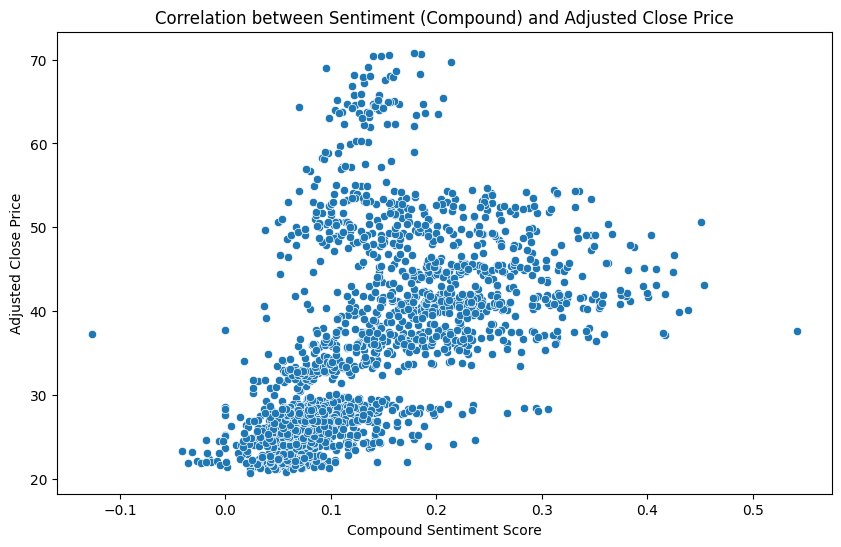

In [104]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='compound', y='Adj Close', data=selected_data)
plt.title('Correlation between Sentiment (Compound) and Adjusted Close Price')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Adjusted Close Price')
plt.show()

In [105]:
# Calculate the Pearson correlation coefficient
correlation = selected_data['compound'].corr(selected_data['Adj Close'])
print(f"The Pearson correlation coefficient between Compound and Adj Close is: {correlation:.3f}")

The Pearson correlation coefficient between Compound and Adj Close is: 0.534


### Splitting Data

In [106]:
# Split the data into train, validation, and test sets
train_size = int(len(selected_data) * 0.7)
valid_size = int(len(selected_data) * 0.85)
train_data_org = selected_data.iloc[:train_size]
valid_data_org = selected_data.iloc[train_size:valid_size]
test_data_org = selected_data.iloc[valid_size:]

### Normalising Data

In [107]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data_org)
train_data = pd.DataFrame(train_data, columns=['Adj Close', 'Compound','Trend'], index=train_data_org.index)
valid_data = scaler.transform(valid_data_org)
valid_data = pd.DataFrame(valid_data, columns=['Adj Close', 'Compound','Trend'], index=valid_data_org.index)
test_data = scaler.transform(test_data_org)
test_data = pd.DataFrame(test_data, columns=['Adj Close', 'Compound','Trend'], index=test_data_org.index)

### Sequence Creation

In [108]:
def create_sequences(data, time_step):
    X, Y = [], []
    for i in range(time_step, len(data)):
        X.append(data.iloc[i-time_step:i].values)
        Y.append(data.iloc[i,0])
    return np.array(X), np.array(Y)

In [109]:
# Create sequences
time_step = 50
X_train, Y_train = create_sequences(train_data, time_step)
X_valid, Y_valid = create_sequences(valid_data, time_step)
X_test, Y_test = create_sequences(test_data, time_step)

### Build the LSTM Combined Dataset Model

In [110]:
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(260, return_sequences= True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(260, return_sequences= True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(260, return_sequences= False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
optimizer = Adam(learning_rate=0.0001)
lstm_model.compile(loss = "mean_squared_error", optimizer = optimizer)
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 50, 260)             │         274,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50, 260)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 50, 260)             │         541,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 50, 260)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 260)                 │         541,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 260)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             261 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,358,501 (5.18 MB)

 Trainable params: 1,358,501 (5.18 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)
history_lstm = lstm_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs = 250, batch_size = 64, callbacks=[early_stopping])

Epoch 1/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1306 - val_loss: 0.0433
Epoch 2/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 3/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0037 - val_loss: 0.0093
Epoch 4/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0032 - val_loss: 0.0083
Epoch 5/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0024 - val_loss: 0.0091
Epoch 6/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020 - val_loss: 0.0112
Epoch 7/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021 - val_loss: 0.0099
Epoch 8/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020 - val_loss: 0.0108
Epoch 9/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023 - val_loss: 0.0094
Epoch 10/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 11/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019 - val_loss: 0.0112
Epoch 12/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

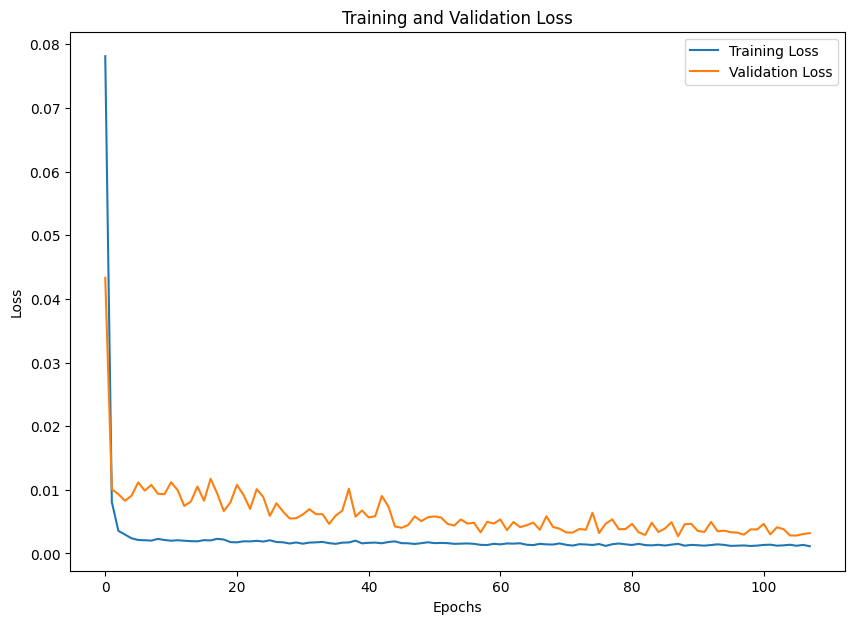

In [112]:
# Plot Loss vs Epochs
plt.figure(figsize=(10, 7))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Predictions

In [113]:
# Predict
train_predict = lstm_model.predict(X_train)
valid_predict = lstm_model.predict(X_valid)
test_predict = lstm_model.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


### Scaling Back to Original

In [114]:
# Inverse transform predictions and original data
train_predict = scaler.inverse_transform(np.column_stack((train_predict, np.zeros(train_predict.shape[0]),np.zeros(train_predict.shape[0]))))
valid_predict = scaler.inverse_transform(np.column_stack((valid_predict, np.zeros(valid_predict.shape[0]),np.zeros(valid_predict.shape[0]))))
test_predict = scaler.inverse_transform(np.column_stack((test_predict, np.zeros(test_predict.shape[0]),np.zeros(test_predict.shape[0]))))
Y_train_inv = scaler.inverse_transform(np.column_stack((Y_train, np.zeros(len(Y_train)),np.zeros(len(Y_train)))))
Y_valid_inv = scaler.inverse_transform(np.column_stack((Y_valid, np.zeros(len(Y_valid)),np.zeros(len(Y_valid)))))
Y_test_inv = scaler.inverse_transform(np.column_stack((Y_test, np.zeros(len(Y_test)),np.zeros(len(Y_test)))))
train_data_inv = scaler.inverse_transform(train_data)
valid_data_inv = scaler.inverse_transform(valid_data)
test_data_inv = scaler.inverse_transform(test_data)

### Residual Analysis

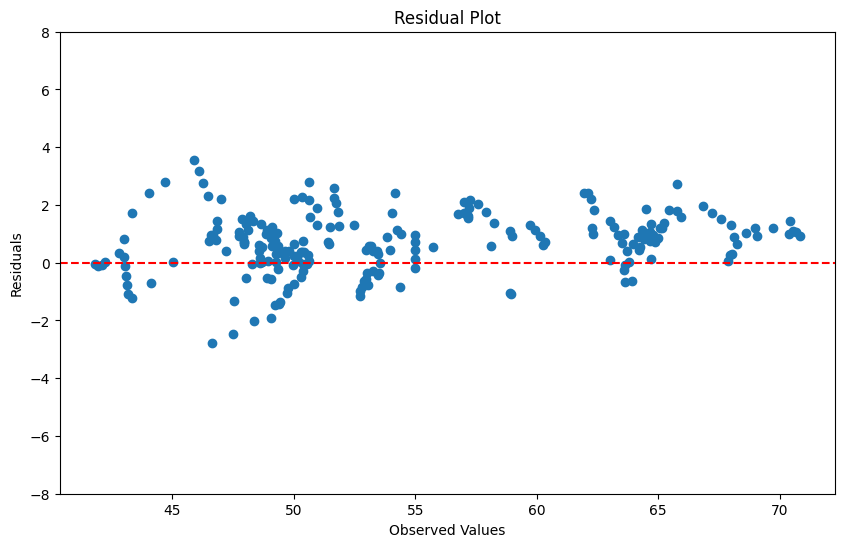

In [115]:
# Calculate residuals
residuals = Y_test_inv[:, 0] - test_predict[:, 0]

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(Y_test_inv[:, 0], residuals)
plt.title('Residual Plot')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim([-8, 8])
plt.show()

### Error Metrics Calculations

In [116]:
mse_train = round(mean_squared_error(Y_train_inv[:, 0], train_predict[:, 0]),2)
mae_train = round(mean_absolute_error(Y_train_inv[:, 0], train_predict[:, 0]),2)
mape_train = round((mean_absolute_percentage_error(Y_train_inv[:, 0], train_predict[:, 0])*100),2)
r2_lstm_train = round((r2_score(Y_train_inv[:, 0], train_predict[:, 0])*100),2)

mse_valid= round(mean_squared_error(Y_valid_inv[:, 0], valid_predict[:, 0]),2)
mae_valid = round(mean_absolute_error(Y_valid_inv[:, 0], valid_predict[:, 0]),2)
mape_valid = round((mean_absolute_percentage_error(Y_valid_inv[:, 0], valid_predict[:, 0])*100),2)
r2_lstm_valid = round((r2_score(Y_valid_inv[:, 0], valid_predict[:, 0])*100),2)

mse_test = round(mean_squared_error(Y_test_inv[:, 0], test_predict[:, 0]),2)
mae_test = round(mean_absolute_error(Y_test_inv[:, 0], test_predict[:, 0]),2)
mape_test = round((mean_absolute_percentage_error(Y_test_inv[:, 0], test_predict[:, 0])*100),2)
r2_lstm_test = round((r2_score(Y_test_inv[:, 0], test_predict[:, 0])*100),2)

In [117]:
# Printing Results
print("\nLSTM  Combined Model Training Metrics:")
print("MSE:", mse_train, "MAE:", mae_train, "MAPE:", mape_train, "Accuracy(R2 Score):", r2_lstm_train)
print("\nLSTM Combined Model Validation Metrics:")
print("MSE:", mse_valid, "MAE:", mae_valid, "MAPE:", mape_valid, "Accuracy(R2 Score):", r2_lstm_valid)
print("\nLSTM Combined Model Testing Metrics:")
print("MSE:", mse_test, "MAE:", mae_test, "MAPE:", mape_test, "Accuracy(R2 Score):", r2_lstm_test)


LSTM  Combined Model Training Metrics:
MSE: 0.51 MAE: 0.52 MAPE: 1.71 Accuracy(R2 Score): 98.93

LSTM Combined Model Validation Metrics:
MSE: 1.74 MAE: 1.01 MAPE: 2.34 Accuracy(R2 Score): 95.45

LSTM Combined Model Testing Metrics:
MSE: 1.53 MAE: 1.01 MAPE: 1.87 Accuracy(R2 Score): 97.41


In [118]:
# Plot the bar chart for errors
data = {
    'Phase': ['Training', 'Validation', 'Testing'],
    'MSE': [mse_train, mse_valid, mse_test],
    'MAE': [mae_train, mae_valid, mae_test],
    'MAPE': [mape_train, mape_valid, mape_test],
}
df = pd.DataFrame(data)
df_long = pd.melt(df, id_vars='Phase', var_name='Metric', value_name='Value')
fig = px.bar(
    data_frame=df_long,
    x='Metric',
    y='Value',
    color='Phase',
    barmode='group',
    title='LSTM Combined Dataset Model: Error Metrics Across Phases',
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig.update_layout(
    xaxis_title='Metric',
    yaxis_title='Value',
    legend_title='Phase',
    yaxis=dict(showgrid=True)
)
fig.show()

### Visualisation

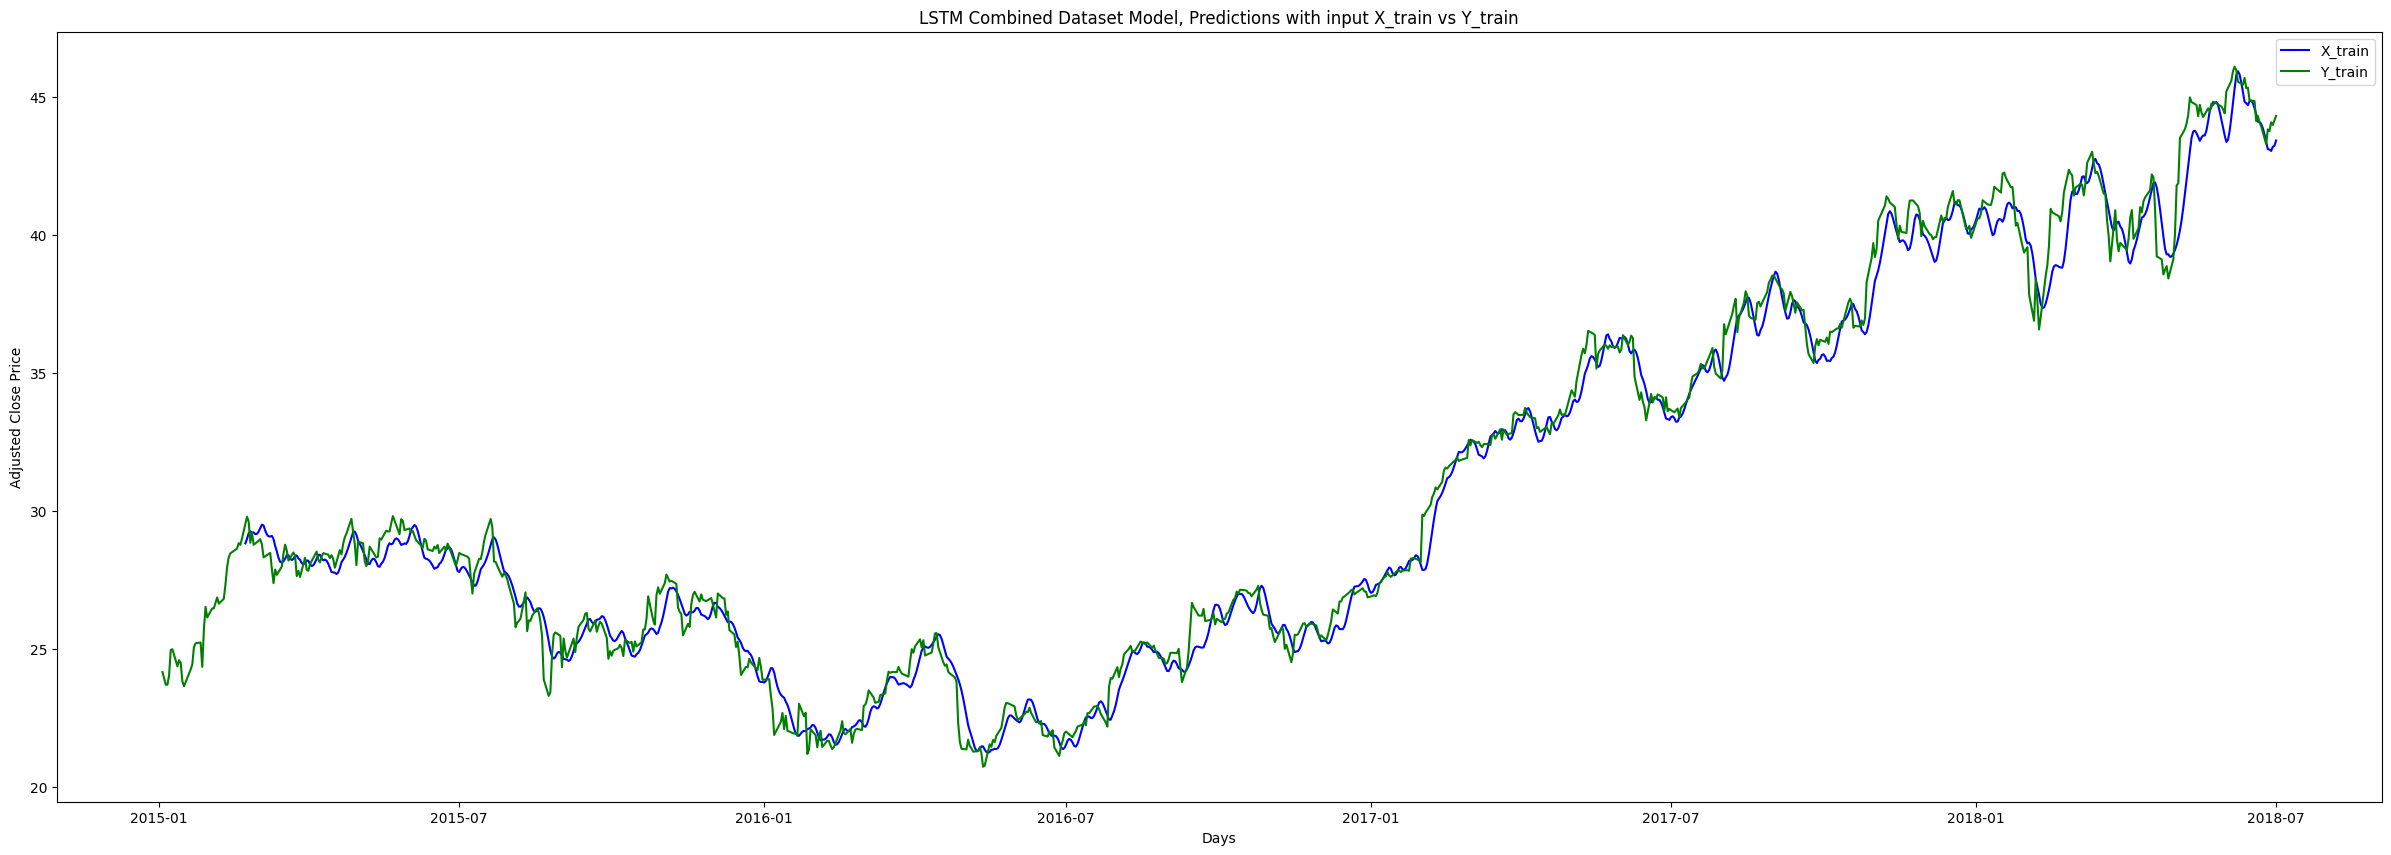

In [119]:
# Visualising training dataset
plt.figure(figsize = (30,10))
plt.plot(train_data.index[time_step:], train_predict[:, 0], color = "b", label = "X_train" )
plt.plot(train_data.index, train_data_inv[:, 0], color = "g", label = "Y_train")
plt.xlabel("Days")
plt.ylabel("Adjusted Close Price")
plt.title("LSTM Combined Dataset Model, Predictions with input X_train vs Y_train")
plt.legend()
plt.show()

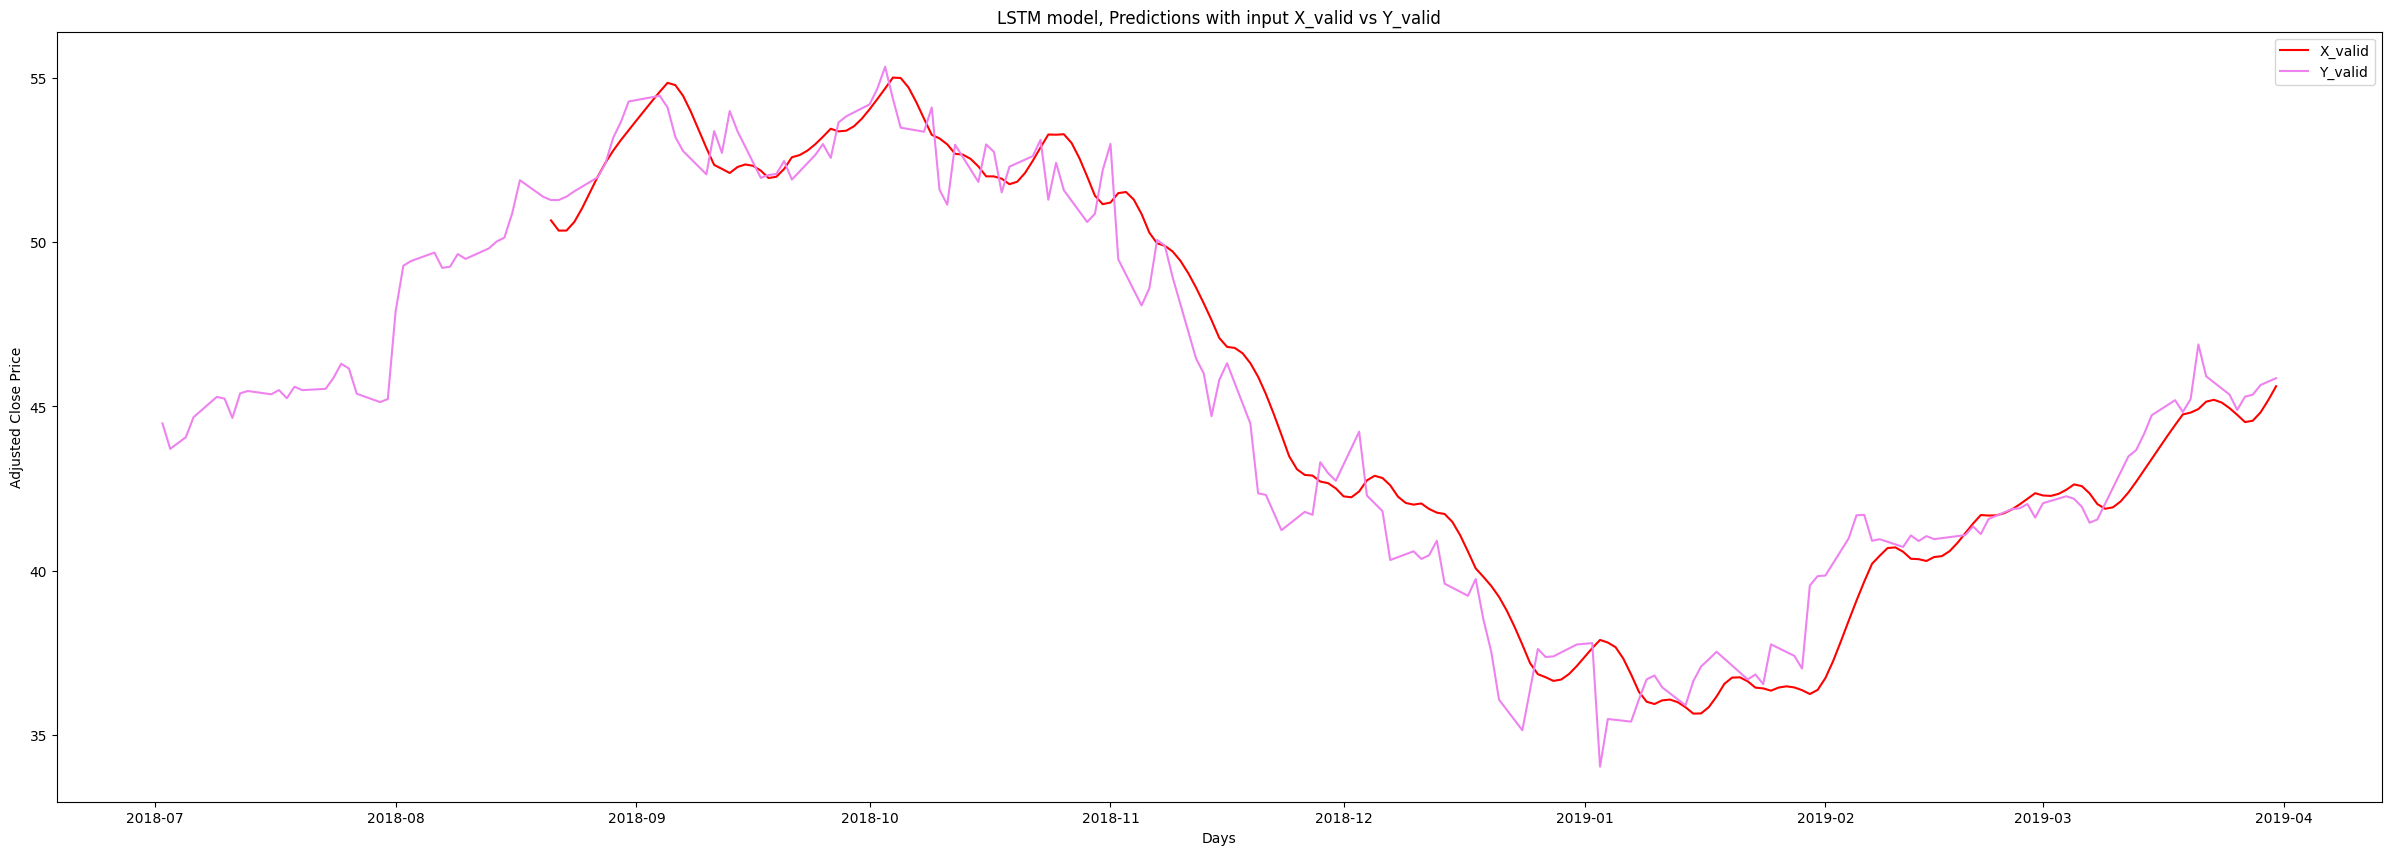

In [120]:
# Visualising validation dataset
plt.figure(figsize = (30,10))
plt.plot(valid_data.index[time_step:], valid_predict[:, 0], color = "red", label = "X_valid" )
plt.plot(valid_data.index, valid_data_inv[:, 0], color = "violet", label = "Y_valid")
plt.xlabel("Days")
plt.ylabel("Adjusted Close Price")
plt.title("LSTM model, Predictions with input X_valid vs Y_valid")
plt.legend()
plt.show()

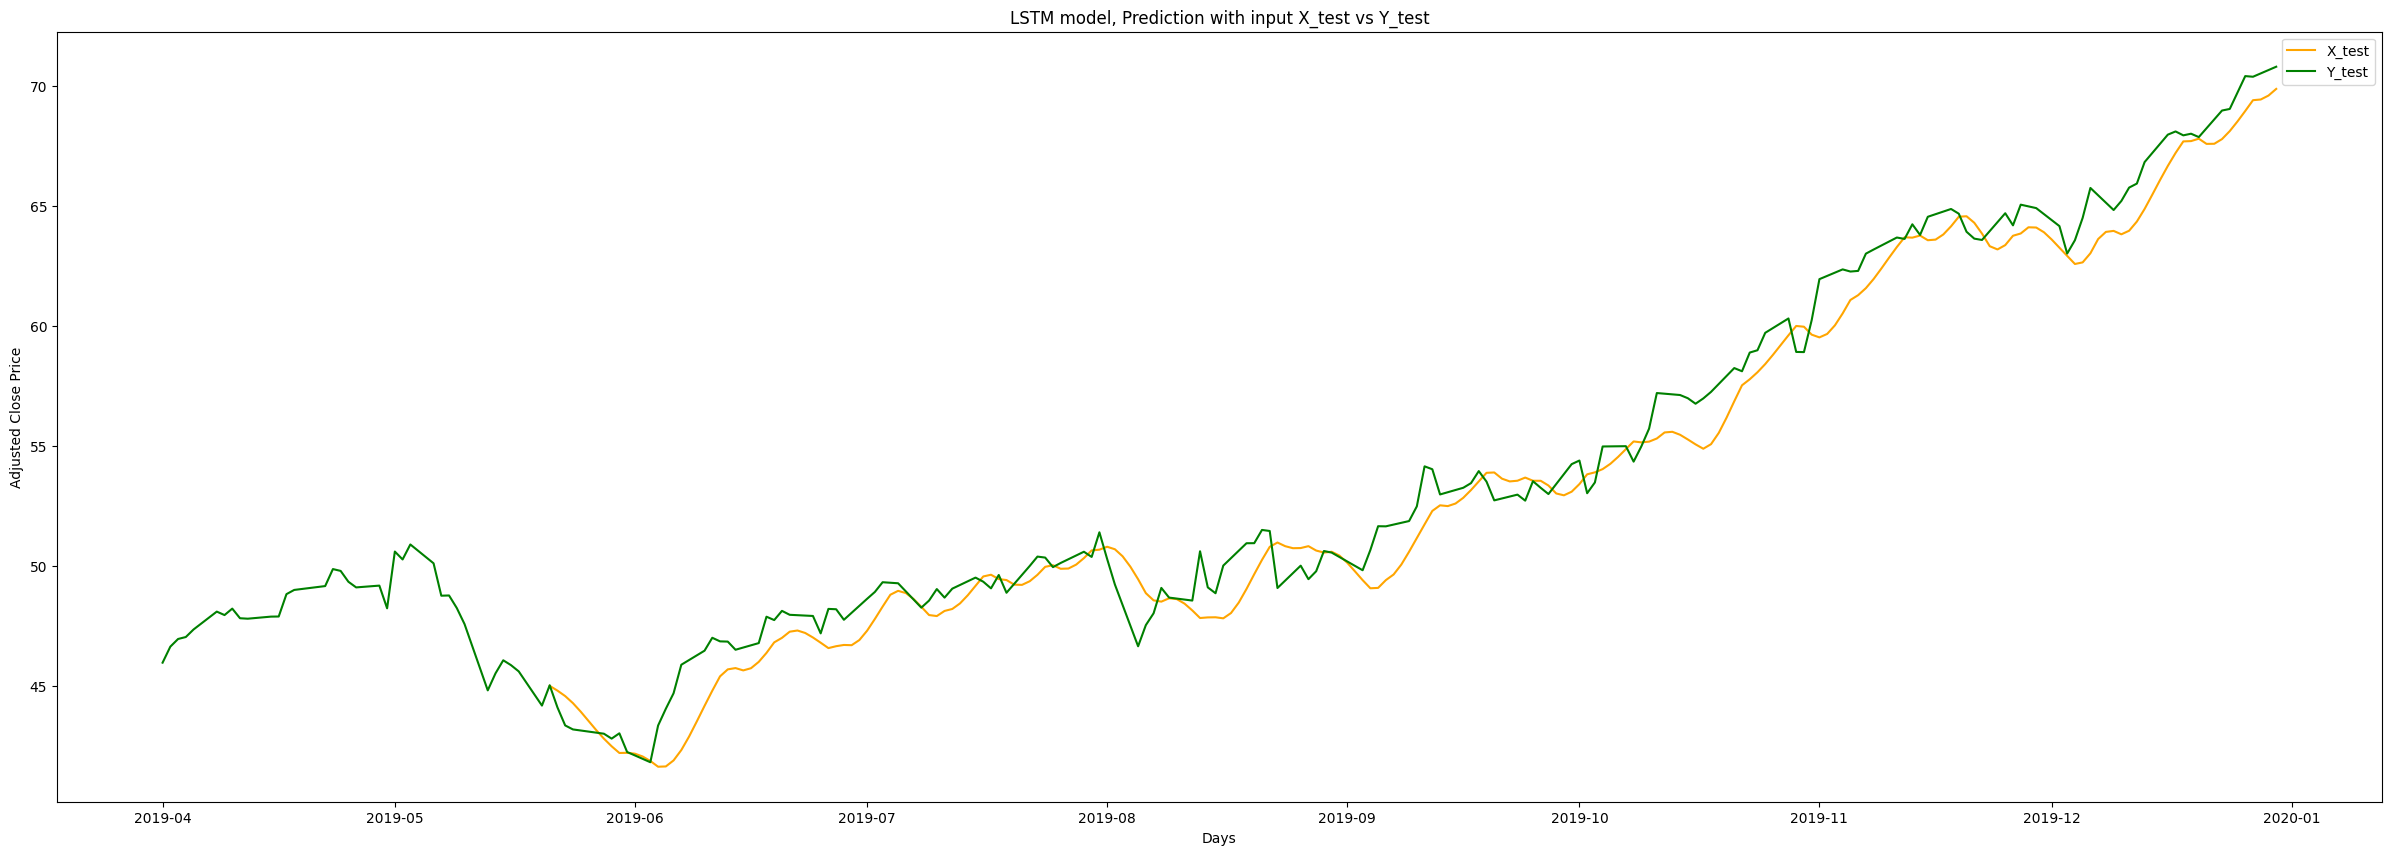

In [121]:
# Visualising testing dataset
plt.figure(figsize = (30,10))
plt.plot(test_data.index[time_step:], test_predict[:, 0], label = "X_test", c = "orange")
plt.plot(test_data.index, test_data_inv[:, 0], label = "Y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Adjusted Close Price")
plt.title("LSTM model, Prediction with input X_test vs Y_test")
plt.legend()
plt.show()

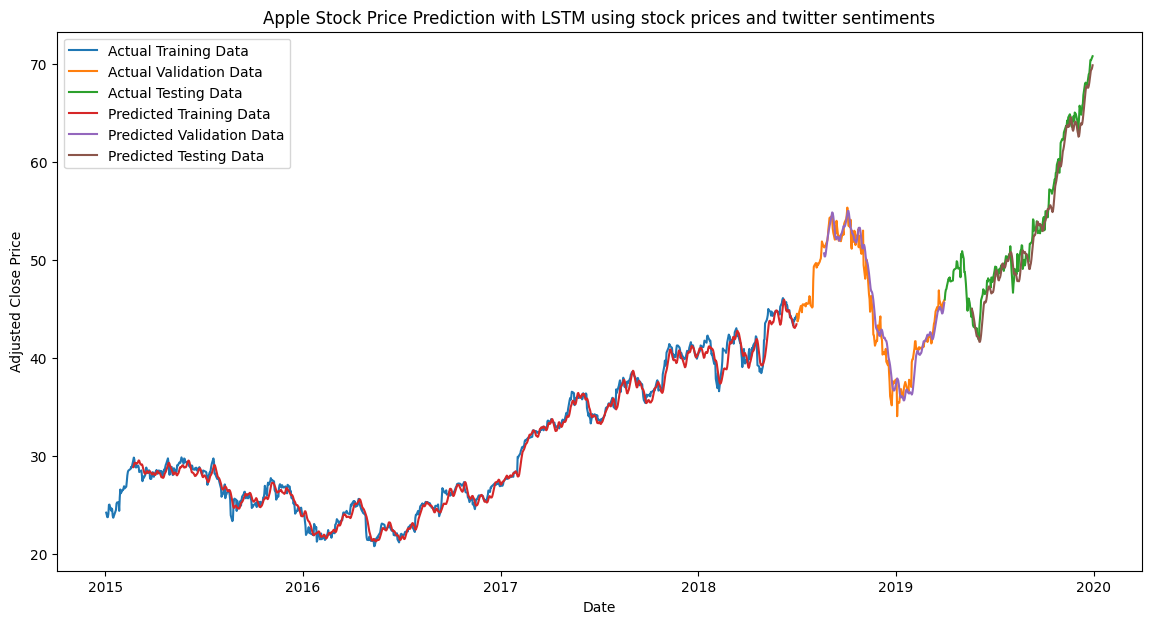

In [122]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data_inv[:, 0], label='Actual Training Data')
plt.plot(valid_data.index, valid_data_inv[:, 0], label='Actual Validation Data')
plt.plot(test_data.index, test_data_inv[:, 0], label='Actual Testing Data')
plt.plot(train_data.index[time_step:], train_predict[:, 0], label='Predicted Training Data')
plt.plot(valid_data.index[time_step:], valid_predict[:, 0], label='Predicted Validation Data')
plt.plot(test_data.index[time_step:], test_predict[:, 0], label='Predicted Testing Data')
plt.title('Apple Stock Price Prediction with LSTM using stock prices and twitter sentiments')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

### Model Comparison

In [123]:
# Comparison of all models
models = pd.DataFrame({
    'Model': ['ARIMA', 'RNN', 'LSTM', 'LSTM Combined Dataset'],
    'MAPE': [20.48, 1.96, 1.48, 1.87]
})
models.sort_values(by='MAPE', ascending=False, inplace=True)
fig = px.bar(
    data_frame=models,
    x='MAPE',
    y='Model',
    color='MAPE',
    color_continuous_scale=px.colors.sequential.Viridis,
    title='Models Comparison'
)
fig.update_layout(
    xaxis_title='Mean Absolute Percentage Error (MAPE)',
    yaxis_title='Model',
    yaxis=dict(categoryorder='total ascending')
)
fig.show()